## Final Project Submission

Please fill out:
* Student name: Jacob Crabb/ Taeho Jeon
* Student pace: full time 
* Instructor name: Greg/Miles
* Blog post URL:


# our goals for this project

predicting housing prices in general, and by zipcode


In [244]:
#import our libraries
import pandas as pd
from pandasql import sqldf
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import seaborn as sns
import folium
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

#set up our sql variables
pysqldf = lambda q: sqldf(q, globals())

In [245]:
#set our dataframe
df = pd.read_csv('kc_house_data.csv')

In [246]:
#check out some of the column values
print(df.condition.unique())

print(df.grade.unique())

[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]


In [247]:
#explore our dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [248]:
#see what relates to what
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [249]:
#look at the low end of values
df.price.sort_values().head()

15279    78000.0
465      80000.0
16184    81000.0
8267     82000.0
2139     82500.0
Name: price, dtype: float64

In [250]:
#make sure that all the values are numbers
df.price.isna().sum()

0

# our first model:
square footage of living space has a high correlation to price, plus intuitively it makes sense to start the model here

In [251]:
#check out just the square foot living column
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

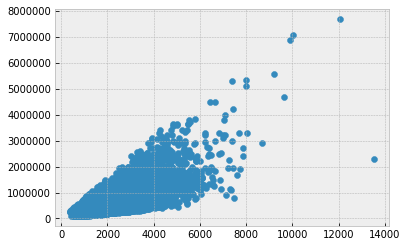

In [252]:
#set some variables for our first plot
X = df.sqft_living
y = df.price

plt.scatter(X, y)
plt.show()

# improving our model
go for a more advanced attempt at least squares regression

In [253]:
slope, intercept, rvalue, pvalue, stderr = linregress(X,y)
first_model_y = slope*X + intercept

In [254]:
#check out our regression variables
linregress(X,y)

LinregressResult(slope=280.8630143588746, intercept=-43988.892194227315, rvalue=0.7019173021377599, pvalue=0.0, stderr=1.9394099144299841)

In [255]:
#look at our models outputs
first_model_y.describe()

count    2.159700e+04
mean     5.402966e+05
std      2.578621e+05
min      5.993042e+04
25%      3.576452e+05
50%      4.924595e+05
75%      6.722118e+05
max      3.758896e+06
Name: sqft_living, dtype: float64

Now we decided to look for outliers:

In [256]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [257]:
#look at the low end of square foot
df.sqft_living.sort_values().tail()

8085      9640
9245      9890
3910     10040
7245     12050
12764    13540
Name: sqft_living, dtype: int64

In [258]:
#finding many outliers
remove_outliers = df.loc[(df.price >= 4500000) | (df.sqft_living >= 8000)].index

In [259]:
#remove those many outliers
df = df.drop(index=remove_outliers)

LinregressResult(slope=269.16985824582997, intercept=-21097.409936777083, rvalue=0.6939245606944319, pvalue=0.0, stderr=1.9011637923074614)


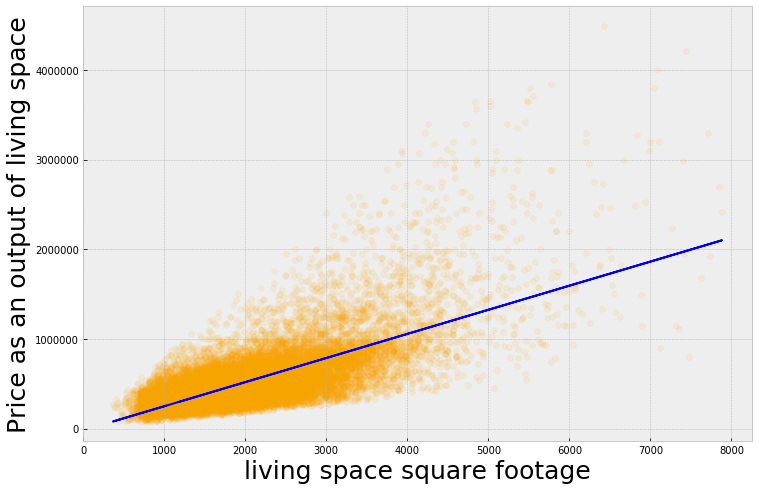

In [260]:
#see our new regression now that many extravaganatly
#large and expensive houses have been removed
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

print(linregress(X,y))

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.1, color='orange')
plt.plot(X, first_model_y, color='blue')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

# next step
attempt to move into multivaraible regression

In [261]:
#change year built to years old
df.yr_built = 2019 - df.yr_built

df = df.rename(columns={'yr_built': 'years_old'})

check for multicolinearity:

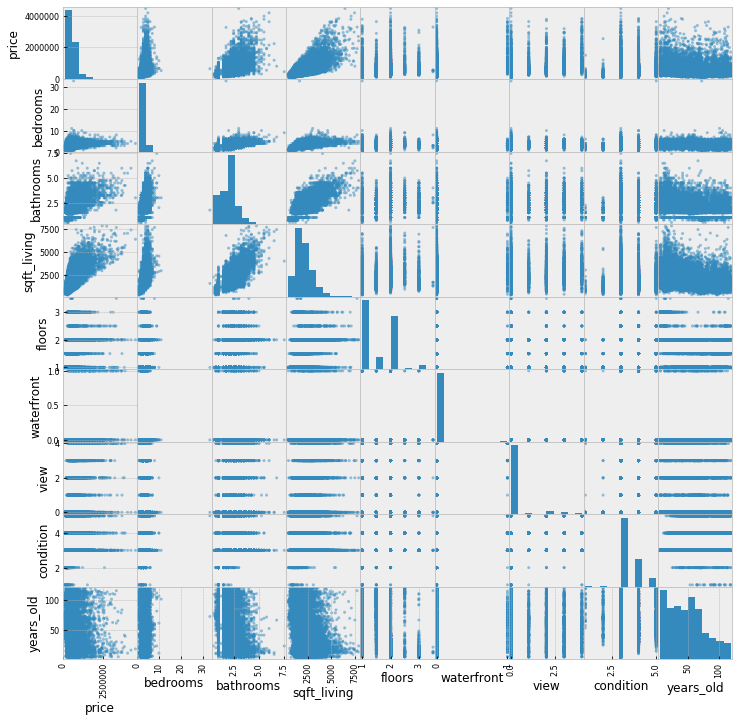

In [262]:
#_ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 
#                                   'sqft_living', 'floors', 'waterfront', 
#                                   'view', 'condition', 'years_old']], figsize=(12, 12))

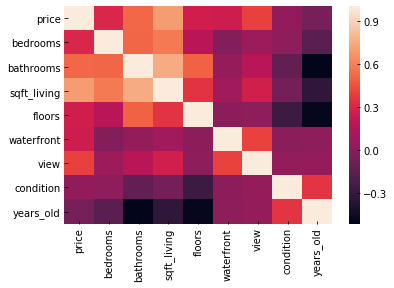

In [263]:
X = df[['price','bedrooms','bathrooms','sqft_living', 'floors', 'waterfront', 'view', 'condition', 'years_old']]
sns.heatmap(X.corr())

Create a function for making multivariable regression with train test splits

In [264]:
def do_predict(X, y):
    """Takes array like objects for X and y"""
    
    #run a train test split on our variables
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.2,
                                                       random_state=27)
    #perform our regression and fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    #set a variable to our r squared for our test set
    r2_score = lr.score(X_test, y_test)
    
    #set a variable to our test prediction
    y_pred = lr.predict(X_test)
    
    #variable for mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    #variable for our root mean squared error
    rmse = np.sqrt(mse)
    
    #perform a cross validation with our data set
    scores = cross_val_score(lr, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    #root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    
    #return a dictionary with our final values
    return lr, {'R2':  r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }

In [265]:
#data cleaning

df.view.replace(to_replace=np.NaN, value=0, inplace=True)
df.sqft_basement.replace(to_replace='?', value=0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float64')
df.waterfront.replace(to_replace=np.NaN, value=0, inplace=True)
df.yr_renovated.replace(to_replace=np.NaN, value=0, inplace=True)

In [266]:
#set variables for our model
X = df.drop(columns=['price','date','id','yr_renovated'], axis=1)
y = df.price

In [267]:
#check our results
print(do_predict(X,y))

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.6972424775428864, 'RMSE': 187621.19964618445, 'RMSE_SCORES': array([182984.81071852, 197437.03919692, 175194.39295787, 200874.51156558,
       164644.82724879, 190109.90881451, 186798.30965372, 195291.03607619,
       200382.2890811 , 214870.30623025]), 'Mean': 190858.74315434563, 'Std': 13572.30947138395})


# Goals:
day 2: try multivariable regression with variables that have low multicolinearity, try to build a function that finds how far away it is from here. do some more data exploration and cleaning. work zipcodes into dummy columns so we can see things like price by zipcode. treat building grade as catagorical if it's not already. for now we will base off of rmse

In [268]:
#set different predictors
X = df.drop(columns=['price','date','id','yr_renovated','years_old', 'floors', 'sqft_above'], axis=1)
y = df.price

In [269]:
#try again
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.671487468061834,
  'RMSE': 195438.62923286212,
  'RMSE_SCORES': array([191089.02738775, 206651.21630602, 185271.70152595, 208601.07262721,
         173902.94029128, 197749.02077307, 195969.33535513, 202526.4455854 ,
         208221.06818028, 209736.52429785]),
  'Mean': 197971.83523299298,
  'Std': 11155.936981837694})

In [270]:
#try with only one predictor to make sure
#there's a difference in results
X = df.loc[:,['sqft_living']]
y = df.price

In [271]:
#compare our results
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.4843275147240348,
  'RMSE': 244862.01378507877,
  'RMSE_SCORES': array([247325.61919197, 259078.74084751, 238730.28144768, 263306.60563947,
         227148.60040225, 246710.97190182, 248511.57649878, 258560.87338009,
         261025.71127371, 266130.45364589]),
  'Mean': 251652.9434229172,
  'Std': 11647.282555389917})

# do more research into predictions by zipcode


In [272]:
#how many different zipcodes do we have?
df.zipcode.value_counts().size

70

In [273]:
#make a new column for seattle zip codes
df['Seattle_zip'] = 0

In [274]:
#try yet more different variables
X = df.loc[:,['sqft_living','condition', 'view', 'waterfront']]
y = df.price

In [275]:
#try again
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5398105877585031,
  'RMSE': 231314.4419182623,
  'RMSE_SCORES': array([226492.02288766, 245538.80408066, 222512.29717036, 246011.0015775 ,
         214510.41322774, 233188.42034836, 234334.57767292, 241844.32496149,
         244964.07430369, 253678.21041749]),
  'Mean': 236307.41466478485,
  'Std': 11670.880394180069})

In [276]:
#lets just pull out all the stops and let everything
#be a predictor for price
X = df.drop(columns=['price','date','id'], axis=1)
y = df.price

In [277]:
#show results
lr, result = do_predict(X,y)

In [278]:
#how'd we do?
print(lr.coef_)
print(result)

[-2.98533670e+04  3.70211735e+04  9.09007057e+01  1.41774472e-01
  1.39307432e+04  5.61211310e+05  5.42257936e+04  2.87377091e+04
  1.01807715e+05  6.21167138e+01  3.86294355e+01  2.58924149e+03
  2.00238838e+01 -5.73950669e+02  6.00180886e+05 -2.03096687e+05
  3.52273505e+01 -3.02905754e-01  0.00000000e+00]
{'R2': 0.698043371987874, 'RMSE': 187372.87504290693, 'RMSE_SCORES': array([182889.11548727, 197190.98328567, 175243.67952161, 200880.01130273,
       164211.13810339, 189912.85166402, 186669.87875023, 195088.7913173 ,
       200102.6408871 , 214877.15909291]), 'Mean': 190706.62494122348, 'Std': 13624.978039957057}


In [279]:
#funciton for seeing what zip codes are in seattle
def is_it_in_seattle(x):
    seattle_zip_codes = [98101, 98102, 98104, 98105, 98108, 98109, 98112 ,98113, 98114,
                     98117, 98103, 98106, 98107, 98111, 98115, 98116, 98118, 98119,
                     98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 98122,
                     98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148,
                     98155, 98160, 98161, 98164, 98165, 98168, 98170, 98146, 98154,
                     98158, 98166, 98174, 98175, 98178, 98190, 98191, 98177, 98181,
                     98185, 98188, 98189, 98194, 98195, 98199, 98198]
    return x in seattle_zip_codes

In [280]:
#test it out
is_it_in_seattle(98101)

True

In [281]:
#set our Seattle_zip column to have true values
#if the zipcode is indeed in seattle
df.loc[df['zipcode'].apply(is_it_in_seattle) == True, 'Seattle_zip'] = 1

In [195]:
#how well does our model perform on homes only in seattle?
X = df.loc[df['Seattle_zip'] == 1,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 1]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5394131799873588,
  'RMSE': 212221.02580439238,
  'RMSE_SCORES': array([216117.64286664, 241451.30868234, 221212.97782964, 226328.56634387,
         214816.67276689, 226922.56177503, 224195.21861831, 224251.1113331 ,
         236310.52207928, 201140.78947549]),
  'Mean': 223274.73717706045,
  'Std': 10684.932728636739})

In [196]:
#what about only houses 'Outside' of seattle
X = df.loc[df['Seattle_zip'] == 0,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 0]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5789857080093423,
  'RMSE': 234868.52650233018,
  'RMSE_SCORES': array([232374.3201982 , 251086.22664367, 221403.22223006, 231585.23310143,
         216842.04566723, 229628.47633311, 226998.41190233, 242242.02639968,
         243562.23068913, 266486.22073857]),
  'Mean': 236220.8413903404,
  'Std': 14096.170277885016})

# making dataframes by zipcode

In [282]:
#use sql commands to call on rows by one zipcode.
def get_dataframe_by_zip(x):
    q = f"SELECT * FROM df WHERE zipcode={x}"
    return pysqldf(q)
    

In [283]:
#perform our regression on each individual
#zipcode and see how we do
zip_result = []
for zipcode in df.zipcode.unique():
    zip_df = get_dataframe_by_zip(zipcode)
    
    X = zip_df.drop(columns=['price','date','id'], axis=1)
    y = zip_df.price

    model, result = do_predict(X, y)
    zip_result.append((zipcode, result['Mean']))


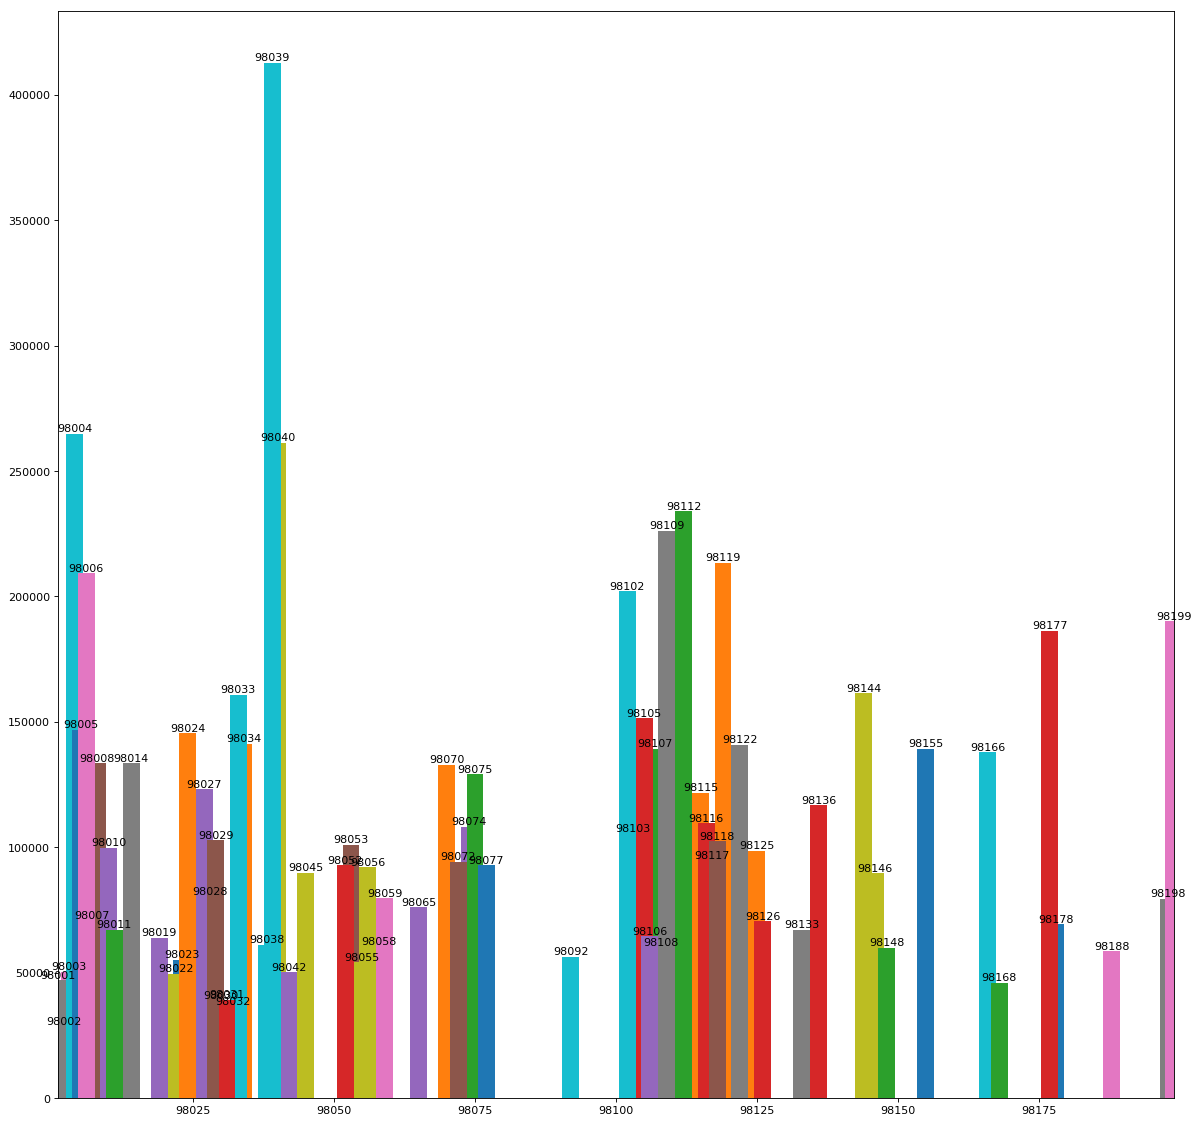

In [199]:
#plot our results
fig, ax = plt.subplots(figsize=(18, 18), dpi=80)

zipcodes = []
rmses = []
for zipcode, mean_rmse in zip_result:
    zipcodes.append(zipcode)
    rmses.append(mean_rmse)
    ax.bar(zipcode, mean_rmse, width=3)

ax.set_xbound(lower=98001, upper=df.zipcode.max())
rects = ax.patches

for rect, label in zip(rects, zipcodes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
           ha='center', va='bottom')

# attempt to use feature ranking to choose our predictors

In [284]:
#set variables for predictors and target
X = df.drop(columns=['price','date','id'])
y = df.price

In [285]:
#feature ranking with scikit learn
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 15)
selector = selector.fit(X, y)

In [286]:
#see our results
print(selector.support_)
print(selector.ranking_)

estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ True  True  True False  True  True  True  True  True  True False  True
 False  True  True  True  True False  True]
[1 1 1 5 1 1 1 1 1 1 2 1 3 1 1 1 1 4 1]
[-2.74936198e+04  3.76053621e+04  1.19693429e+02 -6.24293095e+03
  5.76362674e+05  5.27166149e+04  3.06555549e+04  9.80109302e+04
  4.04574222e+01  2.20208767e+03 -1.57894549e+03  5.41972466e+05
 -5.80777335e+04  4.63169656e+01  1.76766057e+05]
121083217.19879518


In [287]:
#set our features per their recomendation
X = X.loc[:, selector.support_]
y = df.price

In [288]:
#see our results
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.7049454720141348,
  'RMSE': 185219.0187611693,
  'RMSE_SCORES': array([179734.07898355, 193968.69506441, 172873.41746737, 198915.07047574,
         162390.53447415, 187816.53085277, 184318.14691336, 193798.90287665,
         198608.77506965, 209868.09459788]),
  'Mean': 188229.22467755107,
  'Std': 13210.597889926681})